In [1]:
import numpy as np
import matplotlib.pyplot as plt

from math import cos, sin, pi

def unzip(tuples: list[tuple]) -> list[list]:
    return list(zip(*tuples))

### 1b)

Implementieren Sie eine Python-Funktion, die eine Menge von 50 (xi, yi)-Tupeln
(xi, yi) = (xi, mxi + c + ε)
erzeugt (m und c nach Ihrer Wahl), wobei die x−Koordinaten auf einem Intervall [a, b] zuf ¨allig
gleichverteilt sein sollen und ε ∼ N (0, σ2) mit einer Varianz σ2 Ihrer Wahl.


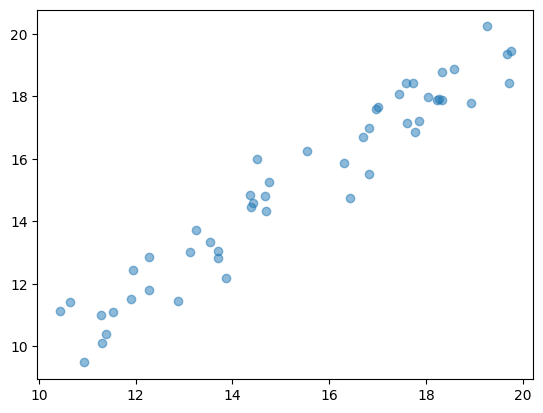

In [ ]:

def random_linear_samples(numsamples: int, a: float, b: float, m: float, c: float, noise_var: float, seed=None) -> list[tuple[float, float]]:
    generator = np.random.default_rng(seed=seed)
    assert b > a
    
    offset = a
    delta = b - a

    x = offset + generator.random(numsamples) * delta
    e = generator.normal(0, noise_var ** 0.5, size=numsamples)
    y = m * x + c + e
    
    assert len(x) == numsamples, f"Expected samples of length {numsamples}. Actual length={len(x)}"
    assert len(y) == numsamples, f"Expected samples of length {numsamples}. Actual length={len(y)}"
    return list(zip(x, y))


# create_circle_samples(5, 2, 5, 42)
def test():
    xy = random_linear_samples(50, a=10, b=20, m=1, c=0, noise_var=1**2, seed=42)
    x, y = list(zip(*xy))
    plt.scatter(x, y, alpha=0.5)
test()


### 1c)

Implementieren Sie eine Funktion, die f ¨ur eine beliebige Menge von (xi, yi)-Tupeln die
Matrix A und den Vektor ~y erzeugt.


In [3]:
def make_A_and_y(xy):
    # plt.scatter(*unzip(xy), alpha=1.0) # debug
    # Unzip [(x1, y1), (x2, y2)] to [[x1, x2], [y1, y2]]
    x, y = np.array(unzip(xy))
    # Add [1, 1, 1...] row to x
    return np.array([x, np.ones(len(x))]).T, y

make_A_and_y(random_linear_samples(10, a=0, b=1, m=1, c=0, noise_var=0**2, seed=42))

(array([[0.77395605, 1.        ],
        [0.43887844, 1.        ],
        [0.85859792, 1.        ],
        [0.69736803, 1.        ],
        [0.09417735, 1.        ],
        [0.97562235, 1.        ],
        [0.7611397 , 1.        ],
        [0.78606431, 1.        ],
        [0.12811363, 1.        ],
        [0.45038594, 1.        ]]),
 array([0.77395605, 0.43887844, 0.85859792, 0.69736803, 0.09417735,
        0.97562235, 0.7611397 , 0.78606431, 0.12811363, 0.45038594]))

### d)

L ¨osen Sie die Gleichung AT Aθ = AT ~y f ¨ur die von Ihnen erzeugte Punktmenge mit einem
Solver Ihrer Wahl.

### e)

Plotten Sie die Punktmenge und die Gerade, die Sie mit Ihrer linearen Regression ermittelt
haben.


m=2.783098, c=5.348698


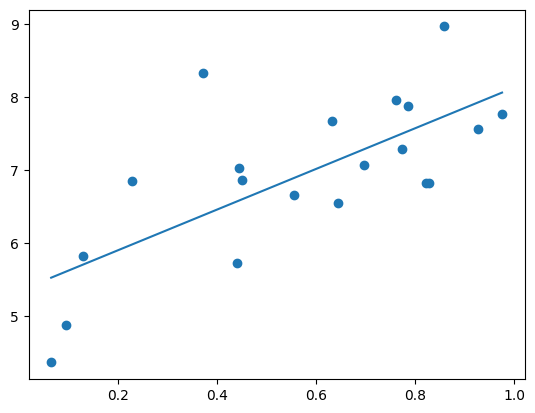

In [4]:
from ex2 import myQRSolver

def test():
    xy_tuple = random_linear_samples(20,
                                    a=0,
                                    b=1,
                                    m=3.2,
                                    c=5,
                                    noise_var=1**2,
                                    seed=42)
    A, vec_y = make_A_and_y(xy_tuple)
    
    # Solve

    m, c = myQRSolver(
        A = A.T @ A,
        b = A.T @ vec_y)
    print(f'{m=:f}, {c=:f}')
    
    
    # Plot points
    px, py = unzip(xy_tuple)
    plt.scatter(px, py)
    
    # Plot line
    linex = np.array([min(px), max(px)]) # Only need two points to draw a line
    liney = m * linex + c
    plt.plot(linex, liney)
test()

### Aufgabe 2 (1+2+2+2 = 7 Punkte)
Nichtlineares Least Squares. Fortsetzung von ¨Ubungsblatt
3, Aufgabe 2.
Gegeben sei wieder die Kostenfunktion

...


### c)
Implementieren Sie eine Funktion, die f¨ur eine Menge von Punkten (xi,yi),i = 1,...,M
und einen gegebenen Parametervektor θ die Jakobi-Matrix J(θ) und den Residuenvektor r(θ)
zur¨uckgibt.

In [5]:
sqrt = lambda x: x ** 0.5

def jakobi_and_resi(xy, theta):
    x, y = np.array(unzip(xy))
    mx, my, r = np.array(theta)
    
    residii =  (sqrt((x - mx)**2  + (y - my)**2) - r)

    gdrx = - (x - mx) / sqrt((x - mx)**2 + (y - my)**2)
    gdry =  - (y - my) / sqrt((x - mx)**2 + (y - my)**2)
    gdrrad = - np.ones(len(x)) * sqrt(2)
    
    J = np.array([gdrx, gdry, gdrrad]).T    
    return J, residii

jakobi_and_resi([(1, 1), (2, 2)], (0, 0, 1))

(array([[-0.70710678, -0.70710678, -1.41421356],
        [-0.70710678, -0.70710678, -1.41421356]]),
 array([0.41421356, 1.82842712]))


### d)
<!-- 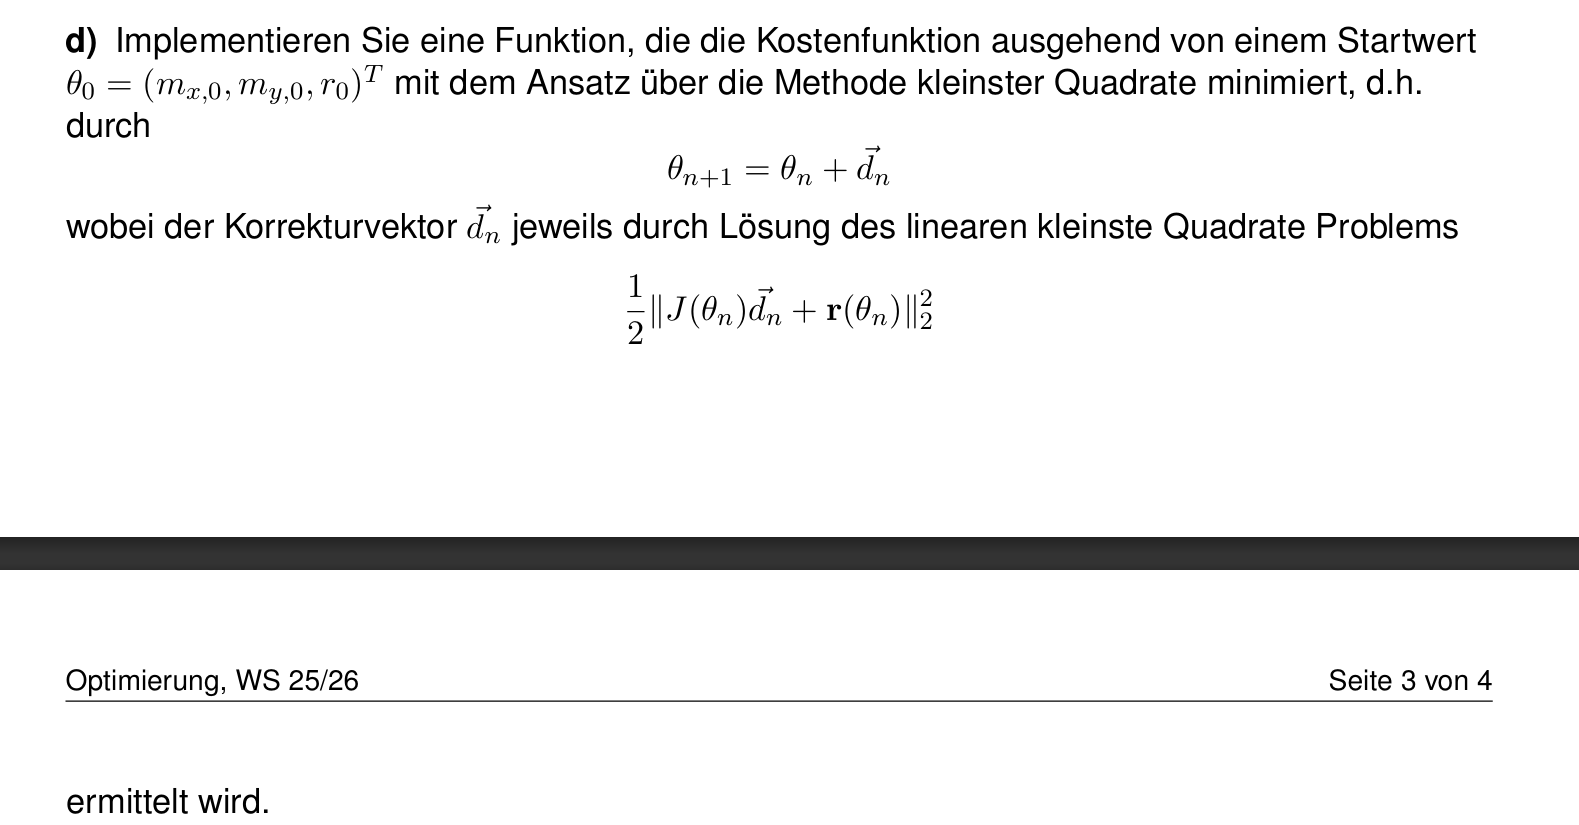 -->
Implementieren Sie eine Funktion, die die Kostenfunktion ausgehend von einem Startwert
θ0 = (mx,0,my,0,r0)T mit dem Ansatz ¨uber die Methode kleinster Quadrate minimiert, d.h.
durch
θn+1 = θn + dn
wobei der Korrekturvektor dn jeweils durch L¨ osung des linearen kleinste Quadrate Problems
1
2 J(θn)dn +r(θn) 2 ermittelt wird

In [6]:
from ex3 import create_circle_samples
def iterate(xy, tn):
    tn = np.array(tn)
    J, r = jakobi_and_resi(xy, tn)
    lhs = J.T @ J
    lhs2 = np.linalg.inv(lhs)
    d = - lhs2 @ (J.T @ r)
    return tn + d

def minimize_error(xy, theta0):
    t0 = theta0
    tn = iterate(xy, t0)
    for n in range(100):
        print(f"Iteration {n=} {tn=}")
        if np.isclose(t0, tn).all():
            break
        t0 = tn
        tn = iterate(xy, t0)
    return tn


### e) 
Verwenden Sie Ihre Implementierung, um das Optimierungsproblem f¨ur 50 zuf¨ allig
erzeugte Punkte (nach Aufgabenblatt 3a) mit der Methode kleinster Quadrate zu l¨ osen.
Starten Sie die Optimierung an der Stelle (0.5,0.1,0.9)T.

In [7]:
print("tn=", minimize_error(create_circle_samples(n=50, r=2.0, noise_var=0.1), (0.5, 0.1, 0.9)))
print("")

print("tn=", minimize_error(create_circle_samples(n=50, r=2.0, noise_var=0.1), (5, 1, 2)))

Iteration n=0 tn=array([-0.03294374,  0.01578629,  1.67504799])
Iteration n=1 tn=array([-0.03166145,  0.0088777 ,  1.92689377])
Iteration n=2 tn=array([-0.03169712,  0.00865931,  2.00066779])
Iteration n=3 tn=array([-0.03169836,  0.00865162,  2.02227589])
Iteration n=4 tn=array([-0.0316984 ,  0.00865135,  2.02860476])
Iteration n=5 tn=array([-0.0316984 ,  0.00865134,  2.03045844])
Iteration n=6 tn=array([-0.0316984 ,  0.00865134,  2.03100137])
Iteration n=7 tn=array([-0.0316984 ,  0.00865134,  2.03116039])
Iteration n=8 tn=array([-0.0316984 ,  0.00865134,  2.03120697])
Iteration n=9 tn=array([-0.0316984 ,  0.00865134,  2.03122061])
tn= [-0.0316984   0.00865134  2.03122061]

Iteration n=0 tn=array([-4.13215898, -1.54978952, -2.18700857])
Iteration n=1 tn=array([ 9.43213614,  3.39499767, -6.9452316 ])
Iteration n=2 tn=array([-2.80527769, -2.67176867, -4.49983606])
Iteration n=3 tn=array([ 7.67447728,  7.21610171, -7.80943911])
Iteration n=4 tn=array([ 2.02620095,  1.4363883 , -0.553275  

Iteration n=0 tn=array([-0.03294374,  0.01578629,  1.67504799]) e=10.050631
Iteration n=1 tn=array([-0.03166145,  0.0088777 ,  1.92689377]) e=4.250674
Iteration n=2 tn=array([-0.03169712,  0.00865931,  2.00066779]) e=3.753181
Iteration n=3 tn=array([-0.03169836,  0.00865162,  2.02227589]) e=3.710496
Iteration n=4 tn=array([-0.0316984 ,  0.00865135,  2.02860476]) e=3.706834
Iteration n=5 tn=array([-0.0316984 ,  0.00865134,  2.03045844]) e=3.706520
Iteration n=6 tn=array([-0.0316984 ,  0.00865134,  2.03100137]) e=3.706493
Change in error is minimal


array([-0.0316984 ,  0.00865134,  2.03100137])

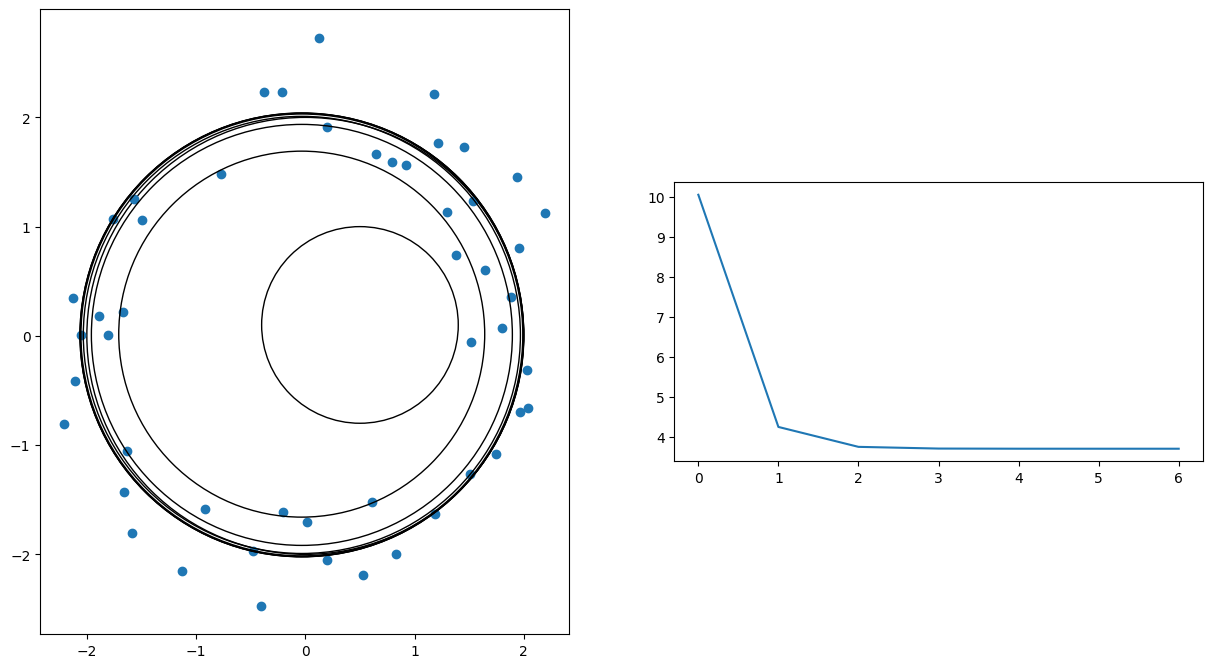

In [8]:
def draw_circle(x, y, radius):
    theta = np.linspace( 0 , 2 * np.pi , 150 )
    a = x + radius * np.cos( theta )
    b = y + radius * np.sin( theta )
    plt.plot(a, b)

def minimize_error_with_plot(xy, theta0):
    fig, axes = plt.subplots(1, 2, figsize=(15, 15))
    x, y = unzip(xy)
    
    # Helpers
    def draw_circle(mx, my, r):
        return axes[0].add_artist(plt.Circle((mx, my), r, fill=False))
    
    def calc_error(mx, my, r):
        # x, y = unzip(xy)
        ri = sqrt((x - mx) ** 2 + (y - my) ** 2) - r
        # ri = []
        # for (xi, yi) in xy:
        #     ri.append((sqrt((xi - mx) ** 2 + (yi - my) ** 2) + r)**2)
        return sum(ri ** 2)
    
    draw_circle(0, 0, 2) # hardcoded for simplicity
    axes[0].scatter(x, y)
    axes[0].set_aspect(1)
    axes[1].set_aspect(0.5)
    
    draw_circle(*theta0)
    
    t0 = np.array(theta0)
    errors = []
    for n in range(50):
        # Calculate
        tn = iterate(xy, t0)
        e = calc_error(*tn)
        
        # Visualize
        print(f"Iteration {n=} {tn=} {e=:f}")
        errors.append((n, e))
        draw_circle(*tn)
        
        # End on circle same
        if np.isclose(t0, tn).all():
            print("Change in circle is minimal")
            break
        
        # End when error same
        if len(errors) > 1 and np.isclose(errors[-2][1], errors[-1][1]):
            print("Change in error is minimal")
            break
        
        t0 = tn

    axes[1].plot(*unzip(errors))
    return tn

minimize_error_with_plot(create_circle_samples(n=50, r=2.0, noise_var=0.1), (0.5, 0.1, 0.9))